In [12]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm, truncnorm
from scipy.special import erf
from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.functions import gaus

# Check chain plot

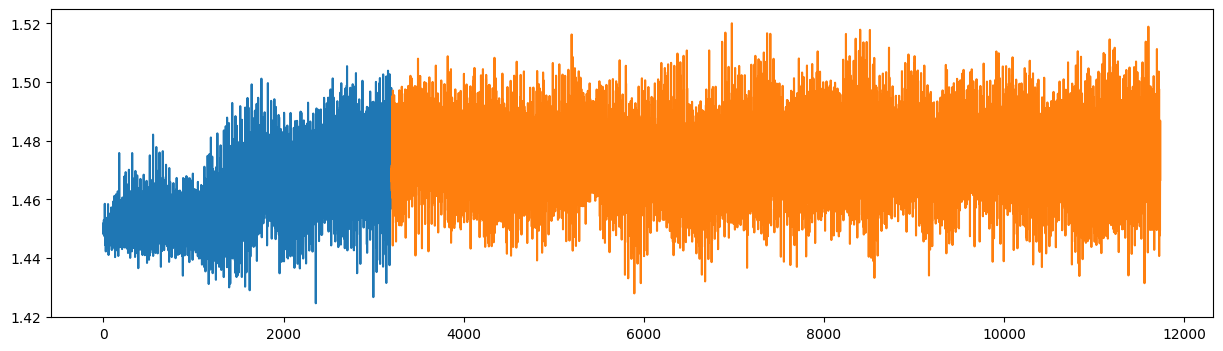

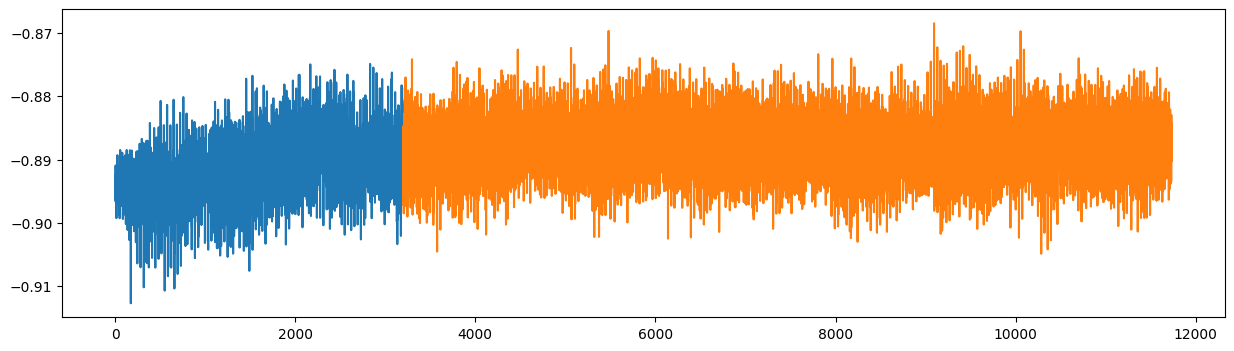

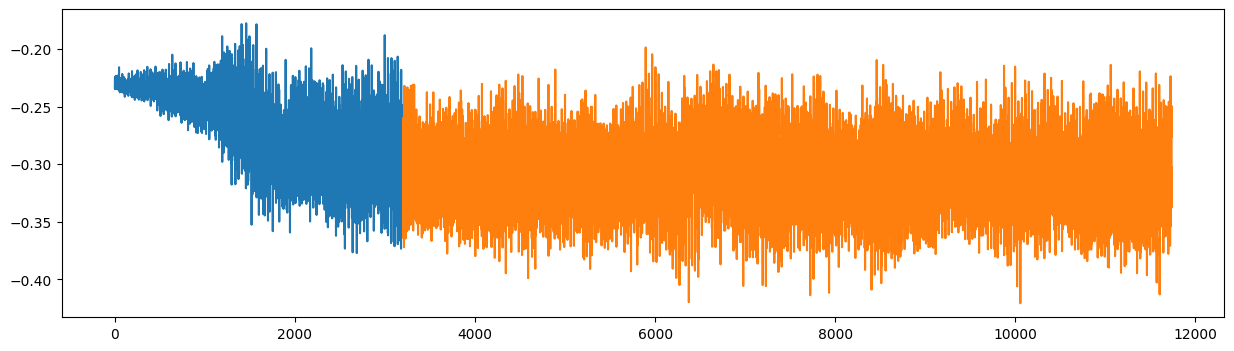

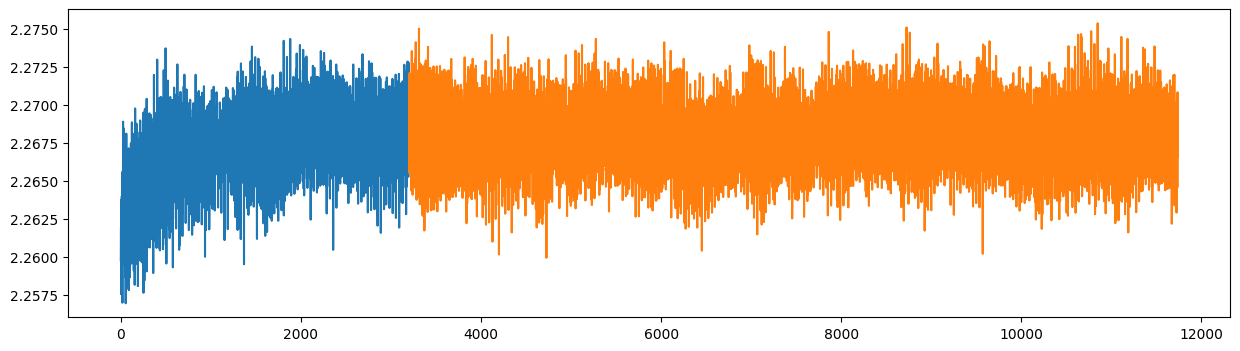

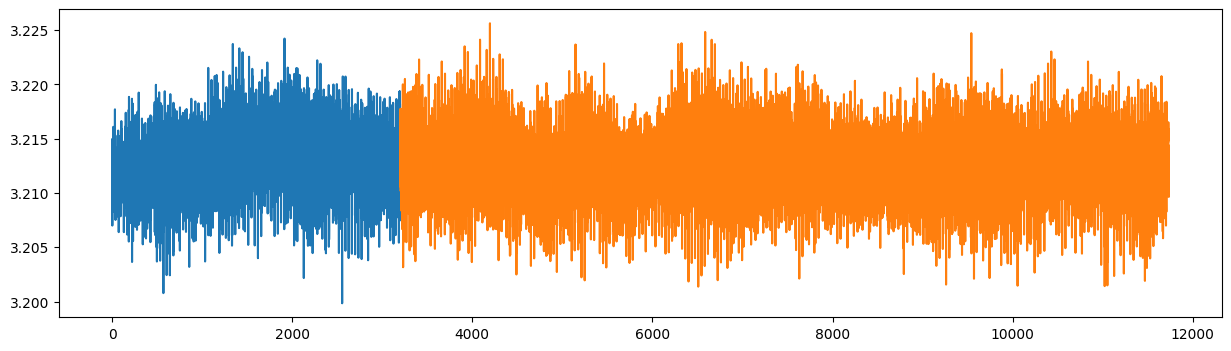

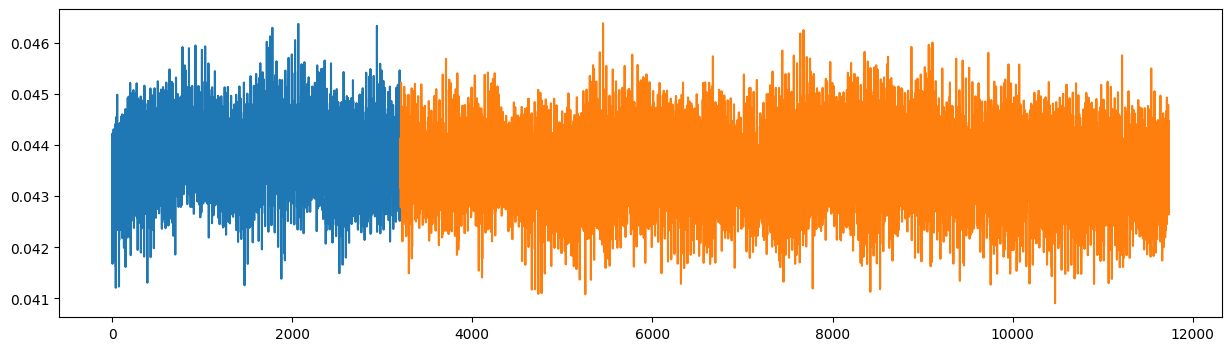

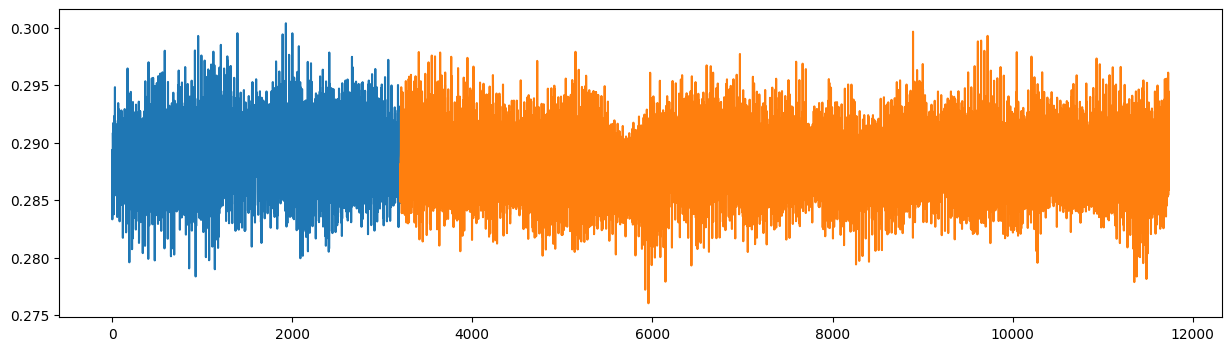

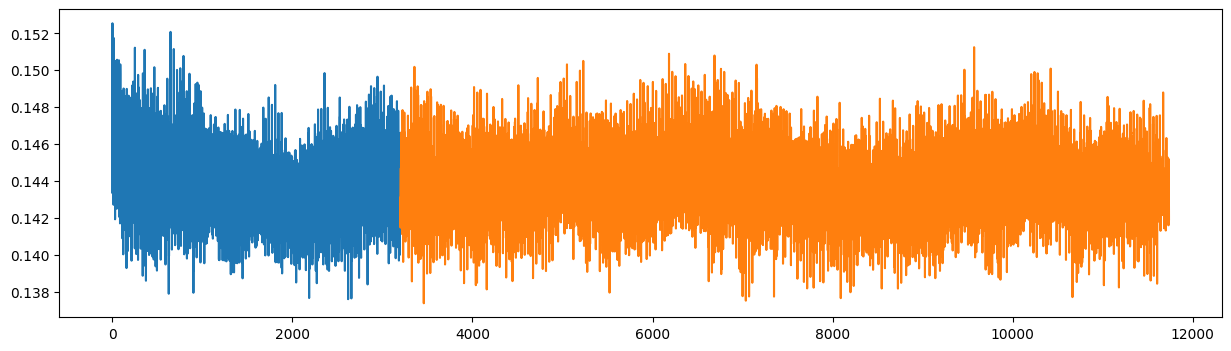

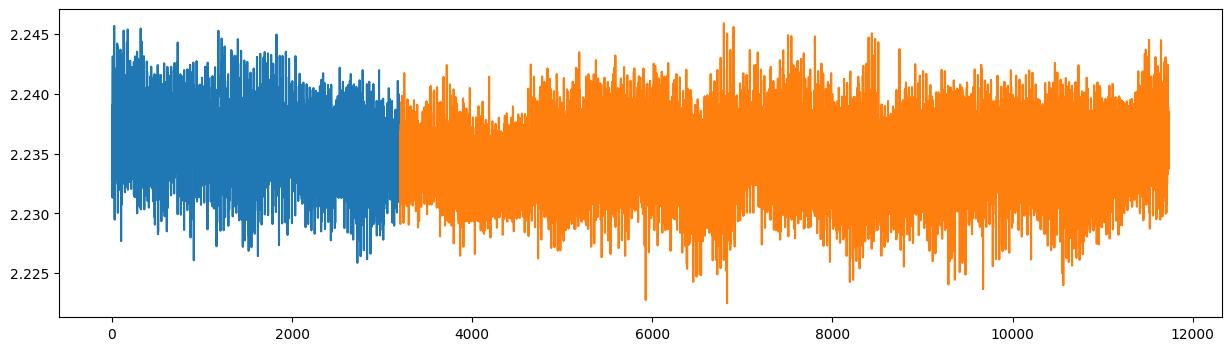

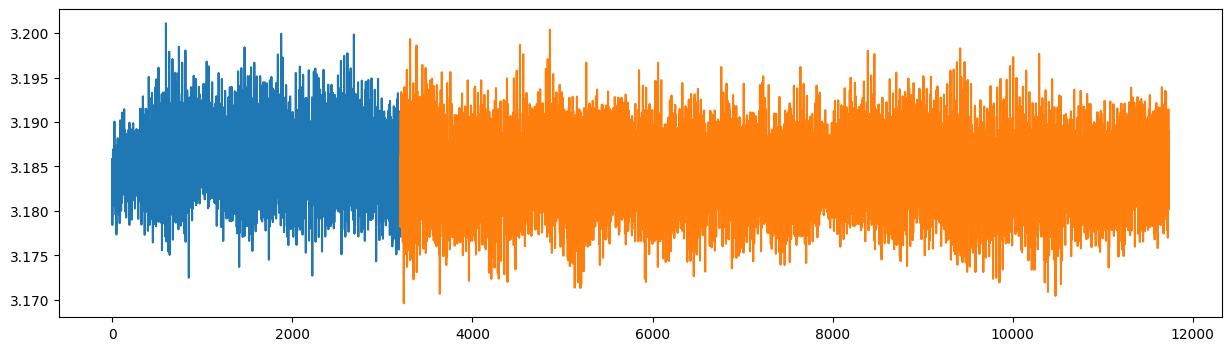

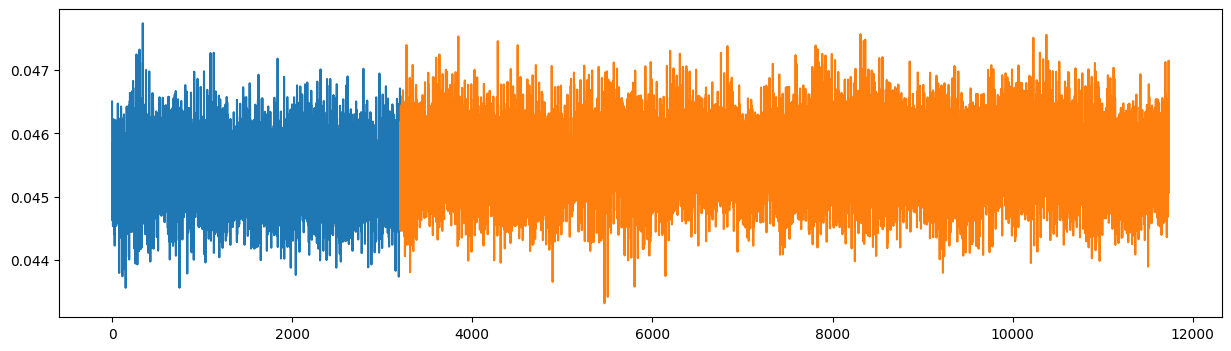

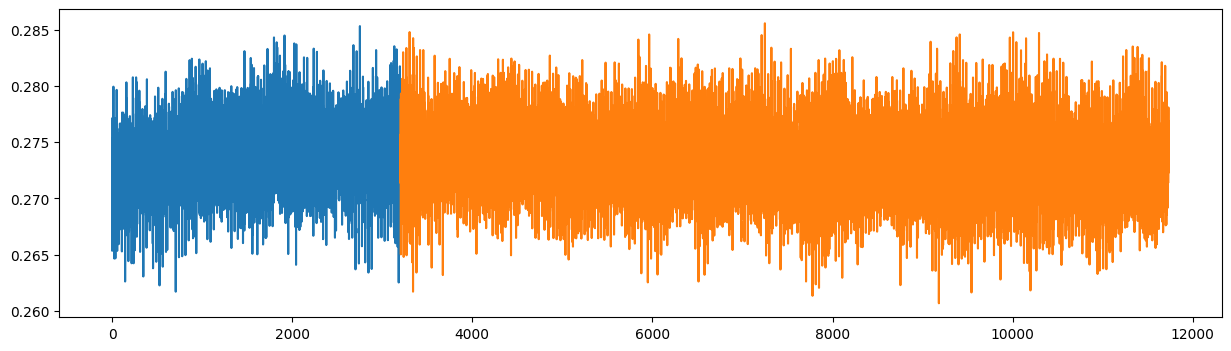

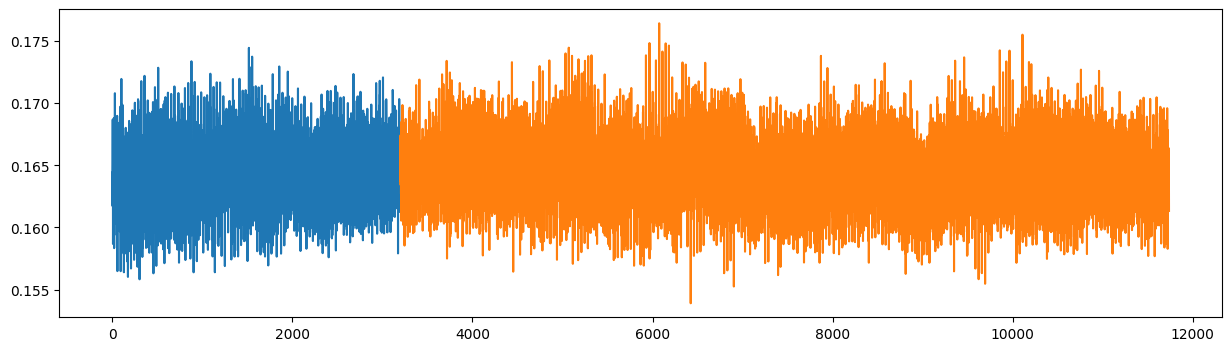

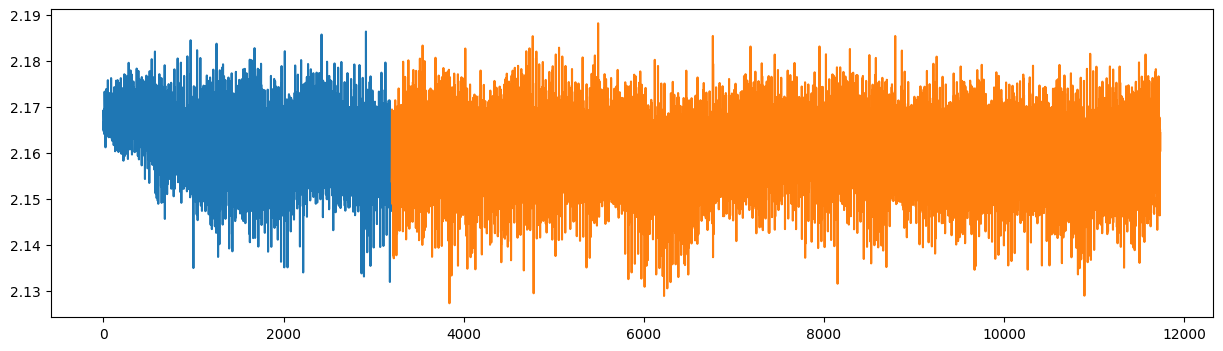

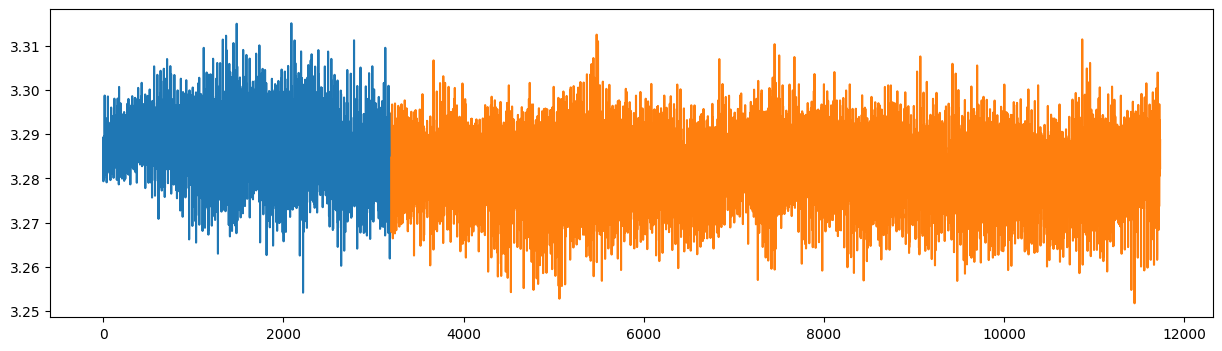

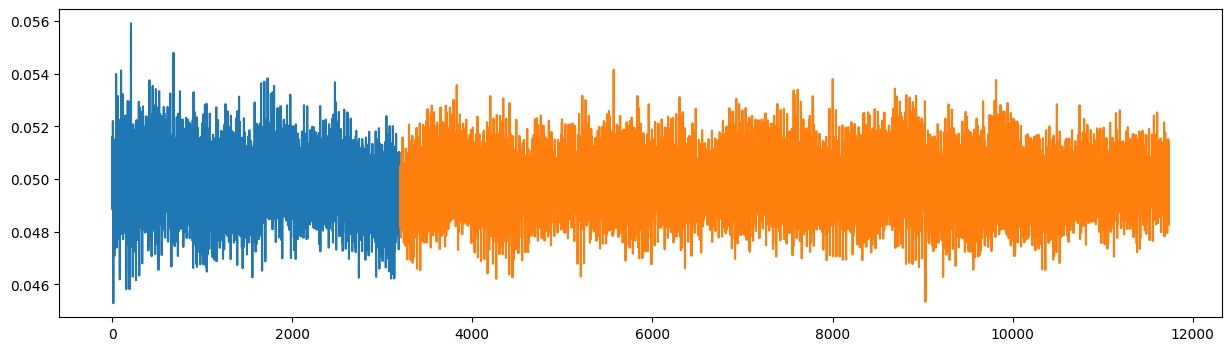

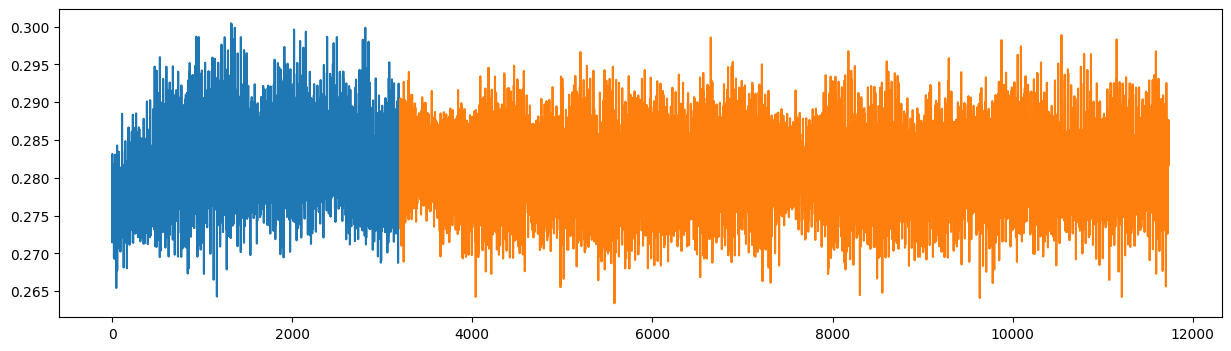

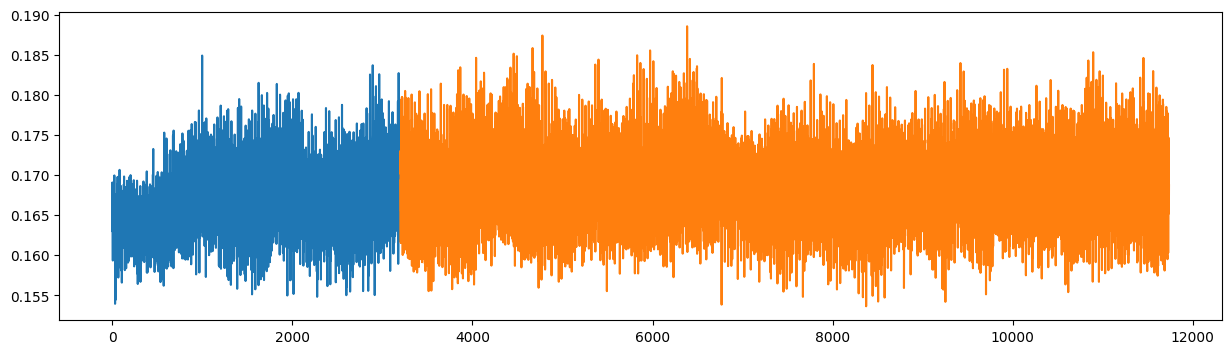

In [ ]:
params = np.load('./fp_fits/chain.npy')

burn = 3200

for param_no in range(18):
    # param_no = 2

    params_out = params[:(burn-1), :].T
    params_in = params[burn:, :].T

    param_in = params_in[param_no]
    param_out = params_out[param_no]

    plt.figure(figsize=(15, 4))
    plt.plot(list(range(0, burn-1)), param_out)
    plt.plot(list(range(burn, len(param_in) + burn)), param_in)

# Save cleaned chain

In [ ]:
burn_in = 3200

params = np.load("./fp_fits/chain.npy")

params_clean = params[burn_in:, :]

np.save("./chain_clean.npy", params_clean)

# Fit with Gaussian

a = 1.475 ± 0.014
b = -0.888 ± 0.005
c = -0.308 ± 0.034
smean_6df = 2.268 ± 0.002
imean_6df = 3.212 ± 0.003
sigma1_6df = 0.044 ± 0.001
sigma2_6df = 0.288 ± 0.003
sigma3_6df = 0.144 ± 0.002
smean_sdss = 2.235 ± 0.003
imean_sdss = 3.184 ± 0.004
sigma1_sdss = 0.046 ± 0.001
sigma2_sdss = 0.273 ± 0.004
sigma3_sdss = 0.165 ± 0.003
smean_lamost = 2.161 ± 0.008
imean_lamost = 3.282 ± 0.008
sigma1_lamost = 0.05 ± 0.001
sigma2_lamost = 0.281 ± 0.005
sigma3_lamost = 0.168 ± 0.005


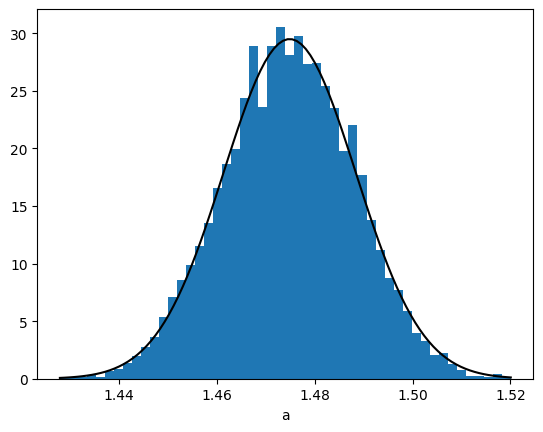

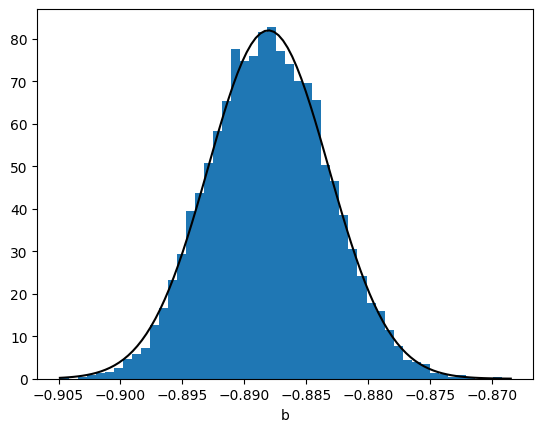

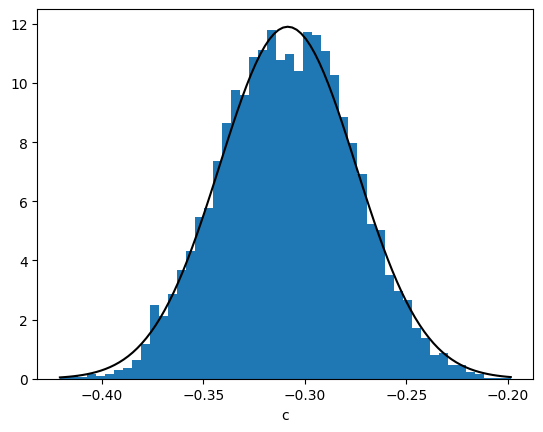

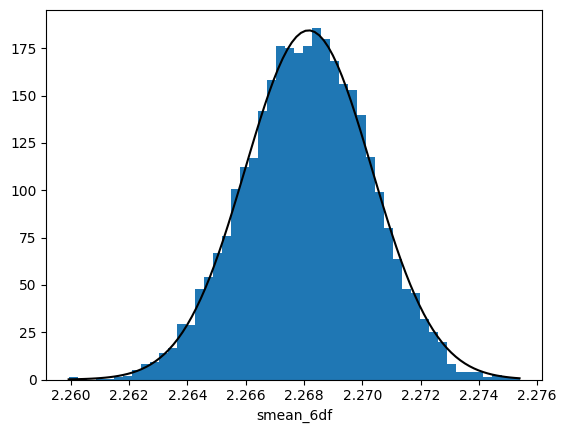

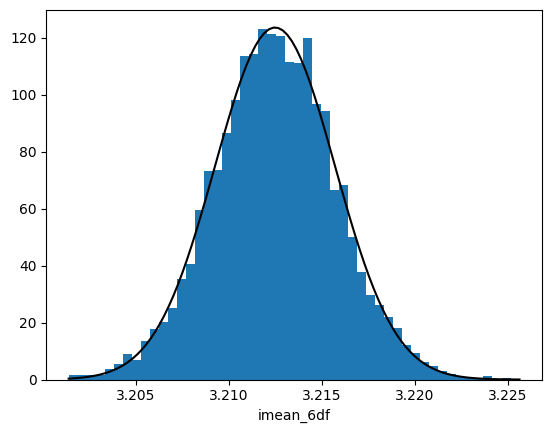

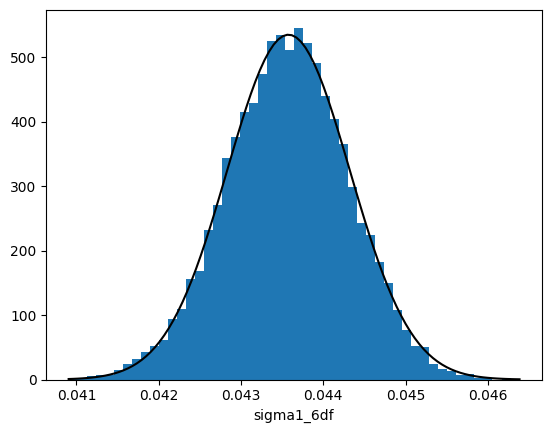

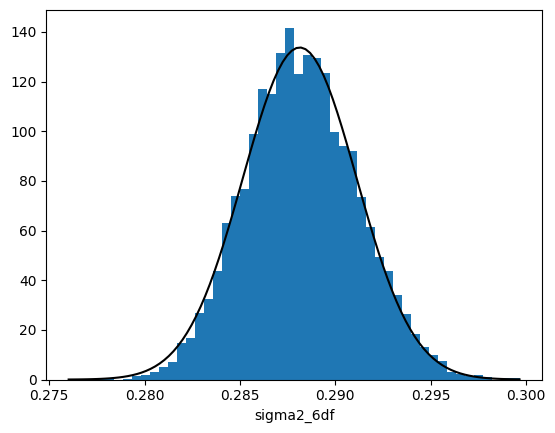

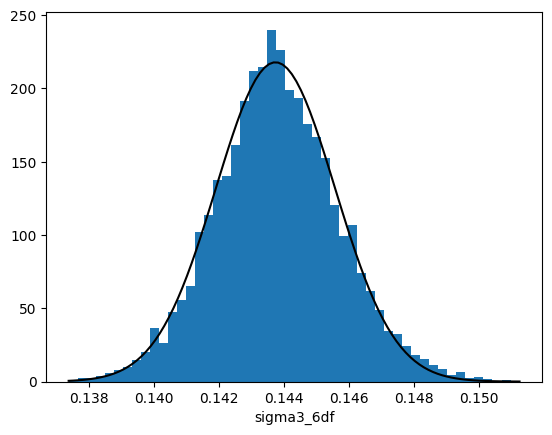

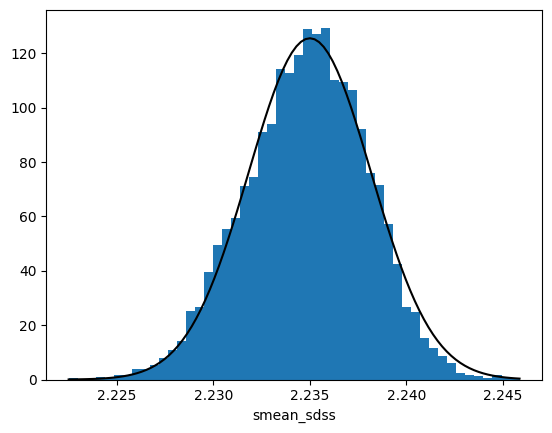

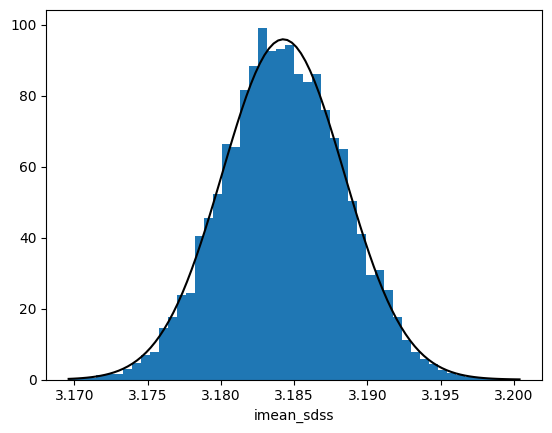

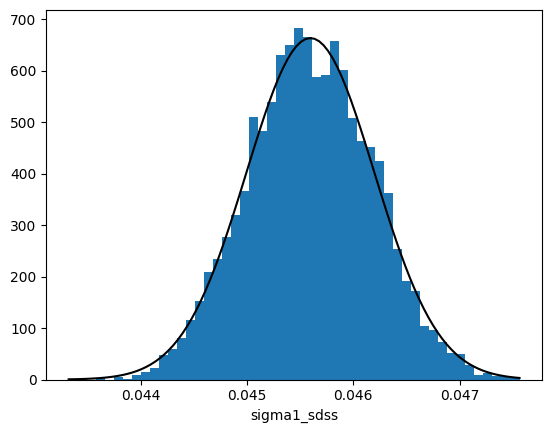

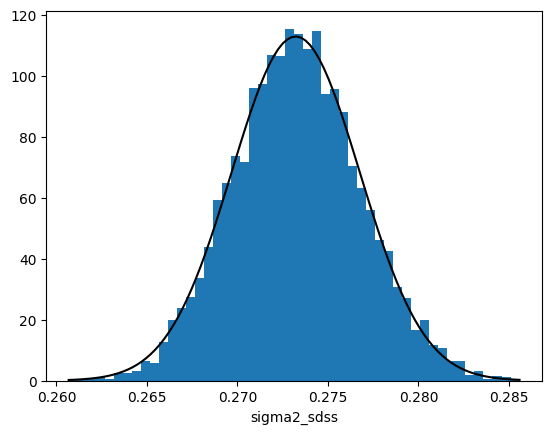

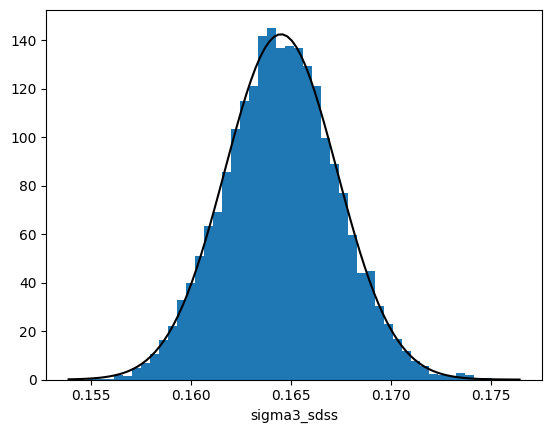

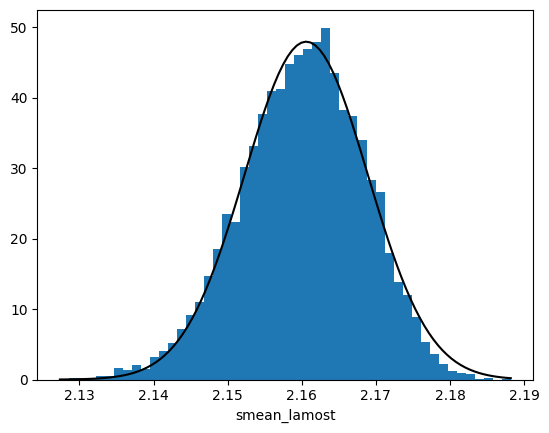

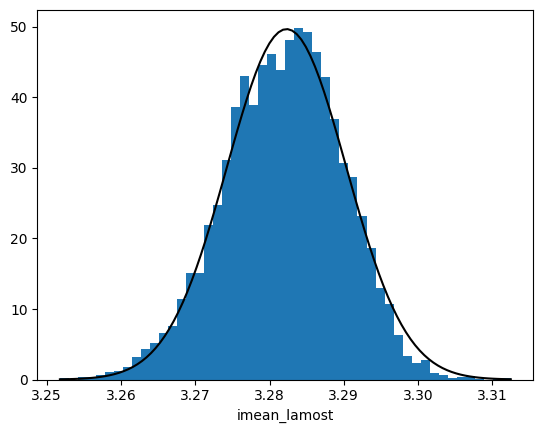

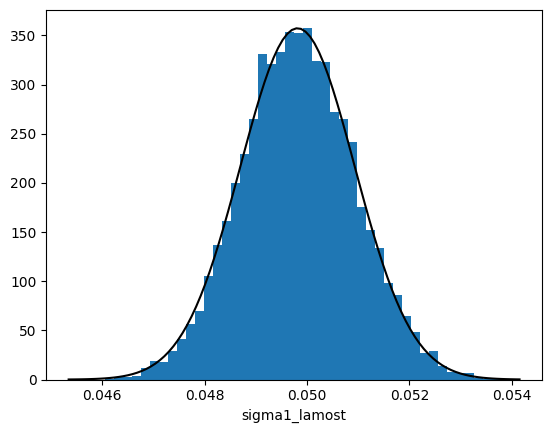

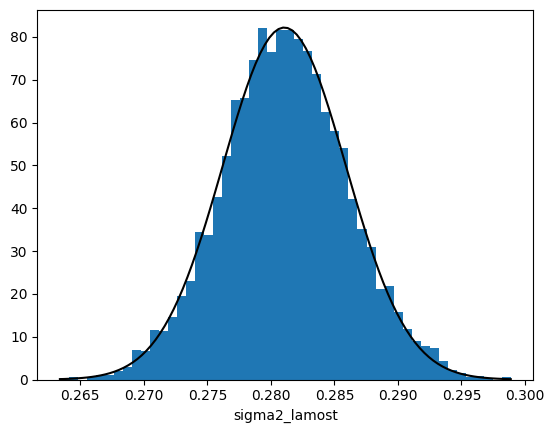

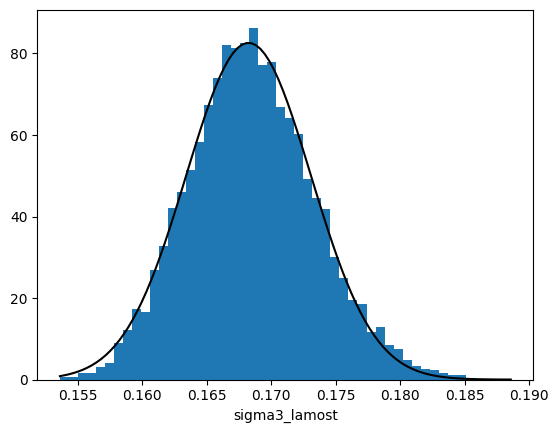

In [63]:
params = np.load('./chain_clean.npy').T
# params = params[3200:, :].T
param_names = [
    "a", "b", "c",
    "smean_6df", "imean_6df", "sigma1_6df", "sigma2_6df", "sigma3_6df",
    "smean_sdss", "imean_sdss", "sigma1_sdss", "sigma2_sdss", "sigma3_sdss",
    "smean_lamost", "imean_lamost", "sigma1_lamost", "sigma2_lamost", "sigma3_lamost",
]

for i in range(18):
    plt.figure()

    # Fit with Gaussian
    xdata = params[i]
    y, x_edges = np.histogram(xdata, bins=50, density=True)
    x = (x_edges[1:] + x_edges[:-1])/2
    popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(xdata), np.std(xdata)])

    # Print mean and std
    mean_, std_ = popt
    print(f"{param_names[i]} = {np.round(mean_, 3)} ± {np.round(std_, 3)}")

    x_trial = np.linspace(xdata.min(), xdata.max(), 100)
    y_trial = gaus(x_trial, *popt)

    # Plot
    plt.hist(params[i], bins=50, density=True)
    plt.plot(x_trial, y_trial, c='k')
    plt.xlabel(param_names[i])

# Save FP fits in a CSV file

In [ ]:
params = np.load('./chain_clean.npy').T
# params = params[3200:, :].T
param_names = [
    "a", "b", "c",
    "smean_6df", "imean_6df", "sigma1_6df", "sigma2_6df", "sigma3_6df",
    "smean_sdss", "imean_sdss", "sigma1_sdss", "sigma2_sdss", "sigma3_sdss",
    "smean_lamost", "imean_lamost", "sigma1_lamost", "sigma2_lamost", "sigma3_lamost",
]

param_summary = []
for i in range(18):

    # Fit with Gaussian
    xdata = params[i]
    y, x_edges = np.histogram(xdata, bins=50, density=True)
    x = (x_edges[1:] + x_edges[:-1])/2
    popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(xdata), np.std(xdata)])

    # Save mean and std
    mean_, std_ = popt

    param_summary.append(mean_)

# Summary for each survey
param_6df = [param_summary[0], param_summary[1], param_summary[2], param_summary[3], param_summary[4], param_summary[5], param_summary[6], param_summary[7]]
param_sdss = [param_summary[0], param_summary[1], param_summary[2], param_summary[8], param_summary[9], param_summary[10], param_summary[11], param_summary[12]]
param_lamost = [param_summary[0], param_summary[1], param_summary[2], param_summary[13], param_summary[14], param_summary[15], param_summary[16], param_summary[17]]

# Save as dataframe
col_names = ["a", "b", "c", "smean", "imean", "s1", "s2", "s3"]
param_all = [param_6df, param_sdss, param_lamost]
df = pd.DataFrame(param_all, index=["6dFGS", "SDSS", "LAMOST"], columns=col_names)

# Calculate rmean
df["rmean"] = df["c"] + df["a"] * df["smean"] + df["b"] * df["imean"]
df = df[["a", "b", "c", "rmean", "smean", "imean", "s1", "s2", "s3"]]

df.to_csv("./fp_fits/fp_fits.csv")

# Logdist Analysis

## Cross-survey check

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 2
Rejected comparison in ('6dFGS', 'LAMOST'): 0


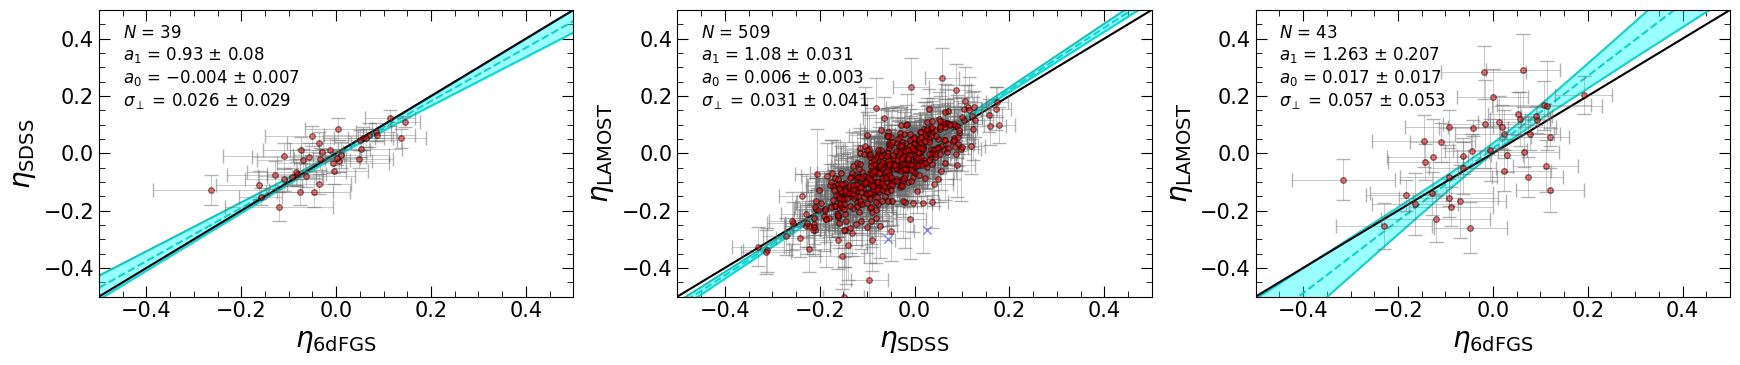

In [73]:
method = "abc_fixed"
SIGMA_CLIP = 2.5

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"./logdist/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"./logdist/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df[f"chisq"] = np.absolute(df[f"logdist_{method}_x"] - df[f"logdist_{method}_y"]) / np.sqrt(df[f"logdist_obs_err_{method}_x"]**2 + df[f"logdist_obs_err_{method}_y"]**2)
    df_rejects = df[df[f"chisq"] > SIGMA_CLIP]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df[f"chisq"] <= SIGMA_CLIP]

    ndata = len(df)
    x = df[f"logdist_{method}_x"].to_numpy()
    xerr = df[f"logdist_obs_err_{method}_x"].to_numpy()
    y = df[f"logdist_{method}_y"].to_numpy()
    yerr = df[f"logdist_obs_err_{method}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_{method}_x"], df_rejects[f"logdist_{method}_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
# fig.savefig('../img/final_plot/fig_11a_internal_consistency_checks_abc_fixed_fp.pdf', bbox_inches='tight', dpi=300)